# Multi-spectrum parallel fitting with spectral-cube and astropy #

## Authors ##
[Eric Koch](https://github.com/e-koch), [Adam Ginsburg](https://github.com/keflavich), [Tom Robitaille](https://github.com/astrofrog)

## Learning Goals ##

* Enabling dask for spectral fitting
* Example of fitting many spaxels in parallel using dask array functions

A "spaxel" refers to the spectrum associated with a single pixel in the spatial dimensions.

## Keywords ##

radio astronomy, spectral-line data cubes, spectral fitting, spatial fitting

## Summary ##

This tutorial presents a proof-of-concept demonstration of spectral fitting a whole spectral-line data cube. Using dask, this example splits the cube into subcubes and runs the fitting in parallel on these subcubes. Here, we use [astropy.modeling](https://docs.astropy.org/en/stable/modeling/) to fit a single Gaussian to a small region in M33 mapped in CO(2-1) by the ALMA 7-m (ACA) array (Project ID 2019.1.01182.S).

## Requires ##

```
pip install astropy spectral-cube dask dask_image aplpy
```


In [1]:
# Basic imports and settings for the notebook.

%matplotlib inline

import warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u


We will download the $\sim10$ MB data cube available online for this tutorial:

In [2]:
from astropy.utils.data import download_file

datafile = download_file(
    'https://zenodo.org/record/4050489/files/M33_ALMA_ACA_12CO21.cutout.fits',
    cache=True, show_progress=True)

from spectral_cube import SpectralCube

# Note that the datafile will not end in ".fits". Because of that, we need to specify the format
# When the file name end in "fits", `format` will not need to be specified 
cube = SpectralCube.read(datafile, format='fits', use_dask=True)

# Use km/s as the spectral unit
cube = cube.with_spectral_unit(u.km / u.s)

This cube is quite small and can be processed in a single chunk by dask (equivalent to using `use_dask=True`). However, larger cubes will be split into $>1$ chunk.

To demonstrate processing a large cube, we will split the tutorial data cube to have 16 chunks with a size of `(300, 16, 16)`. Because the main goal is to fit the spectra, we will keep a single chunk along the spatial axis (set below using `-1` for the 0th axis).

We pass the chunk dimensions using the `chunks` keyword argument for the `SpectralCube.rechunk` function:

In [3]:
cube = cube.rechunk(chunks=(-1, 16, 16))

Each chunk now has a shape of `(300, 16, 16)`, and there are 16 of these chunks in total.

## Identifying spectra to fit ##

Model fitting requires sufficiently bright signal, and we want to begin the fitting with reasonable initial parameters.

We will first identify spectra with high signal-to-noise to fit and create a mask containing the signal. It is important to do this step because fitting is expensive, and poorly-constrained fits will have to be removed later; it is best to ignore unfittable spectra first.

To create the signal mask, we will use a few steps using mathematical morphology to find coherent regions of signal. Signal masking is covered in more detail in [the masking and moments tutorial](https://github.com/radio-astro-tools/tutorials/blob/master/masking_and_moments/masking_and_moments_guide.ipynb).

The goal of the signal mask is to find the most likely regions with real signal, while still recovering the surrounding faint signal. To identify these regions, we will create an initial "low" and "high" signal-to-noise masks, defined as above the $3\sigma$ and $6\sigma$ levels, where the noise level is estimated as the [median absolute deviation](https://docs.astropy.org/en/stable/api/astropy.stats.mad_std.html) along each spectrum:


In [4]:
# Estimate the noise along each line-of-sight
mad_std_plane = cube.mad_std(axis=0)

# Make a low and high mask
low_snr_mask = cube > 3 * mad_std_plane
high_snr_mask = cube > 6 * mad_std_plane

Next, we will label connected regions in `low_snr_mask` and label them. `low_snr_mask` and `high_snr_mask` are both dask arrays. We can use [dask_image.ndmeasure](http://image.dask.org/en/latest/) for morphological operations instead of [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html) for numpy arrays. While both packages perform the same operations, dask images are better for huge files that will not fit into memory.

In [5]:
from dask_image import ndmeasure

# Find connected structures
structure = np.ones((3, 3, 3), dtype=bool)

low_snr_mask_labels, num_labels = ndmeasure.label(low_snr_mask.include(),
                                                  structure=structure)

print(f"Initial number of regions found: {num_labels.compute()}")

Initial number of regions found: 336


Many regions are found. However, we only expect a few real regions of signal based on visual inspection.

Most of the regions are small, spurious regions due to noise. To remove these, we will apply 2 criteria:

1. All regions in `low_snr_mask` must contain $>5$ pixels above $6\sigma$ (the `high_snr_mask`).
2. Regions in `low_snr_mask` must contain $>40$ pixels.

Regions that do not satisfy these criteria are removed from the mask.

The exact number of pixels for each criteria are approximate only and determined by checking different thresholds. A good rule-of-thumb is for regions in `low_snr_mask` to be greater than the number of pixels in the beam. $40$ pixels is approximately the number of pixels within the FWHM of the beam for these data.

In [6]:
num_pixels_in_high_snr_mask = ndmeasure.sum_labels(high_snr_mask.include(),
                                                   label_image=low_snr_mask_labels,
                                                   index=range(1, num_labels.compute() + 1)).compute()

num_pixels_in_low_snr_mask = ndmeasure.sum_labels(low_snr_mask.include(),
                                                  label_image=low_snr_mask_labels,
                                                  index=range(1, num_labels.compute() + 1)).compute()

signal_mask = low_snr_mask.include().compute()
low_snr_mask_labels = low_snr_mask_labels.compute()

for num, (high_pix_num, low_pix_num) in enumerate(zip(num_pixels_in_high_snr_mask, num_pixels_in_low_snr_mask)):
    if high_pix_num > 5 and low_pix_num > 40:
        continue

    signal_mask[low_snr_mask_labels == num + 1] = False

The remaining number of regions is:

In [7]:
signal_mask_labels, num_labels = ndmeasure.label(signal_mask,
                                                  structure=structure)

print(f"Final number of regions found: {num_labels.compute()}")

Final number of regions found: 3


This is far closer to our expectation based on visual inspection.

We apply a final step to better recover faint emission. Because we cut all signal below $3\sigma$, the low level emission around the remaining regions will not be included. To improve the recovery, we extend the signal mask by 1 spectral channel in each direction:

In [8]:
# Extend the signal mask by 1 spectral channel in each direction for the remaining structures
# This is to include low level emission below the 3 sigma cutoff, but only for the remaining structures
# that are likely to be real.
# The same operation can be achieved by "rolling"

posns = np.where(signal_mask > 0)

signal_mask[posns[0] + 1, posns[1], posns[2]] = True
signal_mask[posns[0] - 1, posns[1], posns[2]] = True

In total, 3 regions satisfy our criteria as "real" emission.

We will mask the cube in two ways for this tutorial:

* `masked_cube` which is masked with `signal_mask` -- We will use this cube to estimate initial parameters by making moment maps.
* `spatmasked_cube` which only masks in the *spatial dimensions* -- We will use this cube for fitting so that the fits use the entire spectrum whereever there is sufficiently bright signal.

In [9]:
masked_cube = cube.with_mask(signal_mask)

spatmasked_cube = cube.with_mask(signal_mask.sum(axis=0) > 0)

To visualize the structures kept in the signal mask, we create a moment 0 (integrated intensity) map:

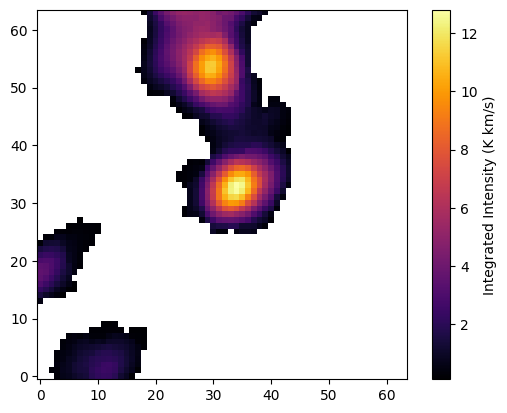

In [10]:
masked_moment0 = masked_cube.moment0()
plt.imshow(masked_moment0.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Integrated Intensity (K km/s)')


The regions kept after masking is what we expect: 2 Giant Molecular Clouds (GMCs) in the field-of-view that are connected by faint emission (so these count as 1 region in the mask) and two fainter regions that have been cut-off in the tutorial data.

The white regions are where the data has been masked completely (i.e., the whole spectrum is now a `NaN` in the masked cubes).

All of the unmasked spectra will be included in the fitting below.

## Initial guesses ##

We want to make reasonable initial model guesses to assist the fits in converging. For a single Gaussian model, we need to estimate:
1. The peak amplitude
2. The mean velocity (velocity at the peak)
3. The line width (standard deviation of the Gaussian)

These 3 quantities can be estimated by (1) the peak of each spectra; (2) the moment 1 (centroid); and (3) the line width from the second moment or an equivalent estimator.

To make these maps, we will use `masked_cube`, the full signal mask including along the spectral dimension.

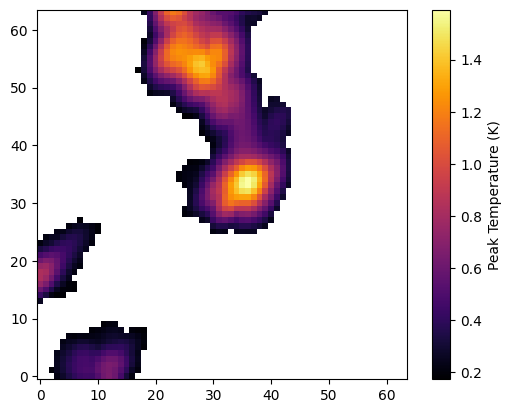

In [11]:
# 1. peak of each spectra
masked_peaktemp = masked_cube.max(axis=0)
plt.imshow(masked_peaktemp.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Peak Temperature (K)')


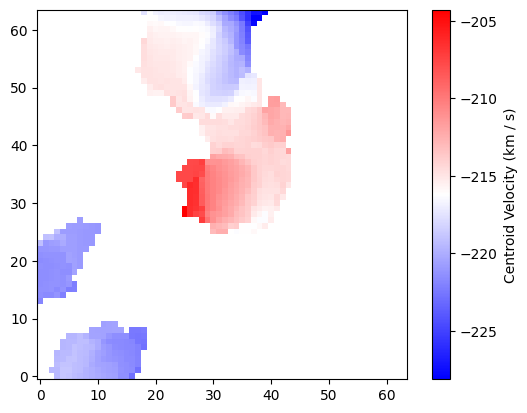

In [12]:
# 2. Moment 1 (centroid velocity)
masked_moment1 = masked_cube.moment1()
plt.imshow(masked_moment1.value, origin='lower', cmap='bwr')
cbar = plt.colorbar()
cbar.set_label('Centroid Velocity (km / s)')


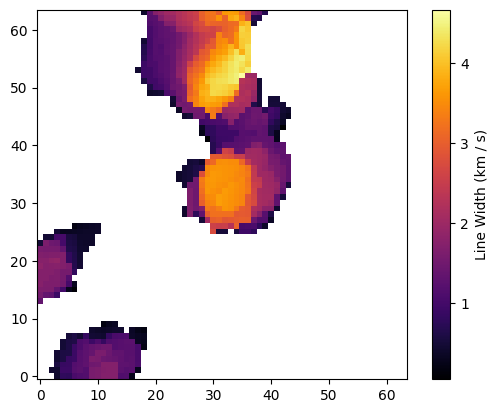

In [13]:
# 3. Second moment line width
masked_lwidth = masked_cube.linewidth_sigma()
plt.imshow(masked_lwidth.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Line Width (km / s)')


An alternate "effective" line width can be made by assuming that the spectra are a single Gaussian. For the tutorial data cube, this a reasonable assumption.

The "effective" line width uses the relation between peak intensity, line width, and integrated intensity for a Gaussian:
$$ I = \sqrt{2\pi} T_{\rm peak} \sigma. $$

Solving for the "effective" line width gives:
$$ \sigma = \frac{I}{\sqrt{2\pi} T_{\rm peak}}. $$

See [Heyer et al. (2001)](https://ui.adsabs.harvard.edu/abs/2001ApJ...551..852H/abstract) and [Sun et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...860..172S/abstract).


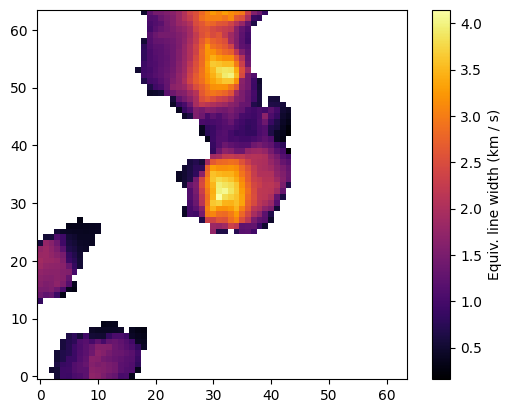

In [14]:
# 3b. "equivalent" line width
masked_equivwidth = masked_moment0 / (np.sqrt(2 * np.pi) * masked_peaktemp)
plt.imshow(masked_equivwidth.value, origin='lower', cmap='inferno')
cbar = plt.colorbar()
cbar.set_label('Equiv. line width (km / s)')


The line widths estimated from the second moment and "effective" methods are similar for the tutorial data. We will use the effective line width as the initial line width guesses for the fitting, but the line width from the second moment works similarly well.

These three maps will be fed in as "guesses" for fitting.

## Chunk fitting ##

Before fitting the whole cube, we test the fitting process on a single spectrum. The center pixel has a strong CO(2-1) detection, so we will use it for testing. Note that this is the same spectrum 
that we use in the [general fitting with spectral-cube tutorial](https://github.com/radio-astro-tools/tutorials/blob/master/spectral_fitting/fitting_with_spectralcube.ipynb).


Both here and for fitting the whole cube, we will use `spatmasked_cube`, where only the spatial extent of the signal mask is used. This allows the full spectrum to be included in the fit where we expect there to be bright emission.

In [15]:
from astropy.modeling import models, fitting

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude              mean              stddev     
                              km / s             km / s     
    ------------------ ------------------- -----------------
    1.0974557824901818 -211.55636300015527 4.187837281376681


Text(0.5, 0, 'Radio Velocity (km /s)')

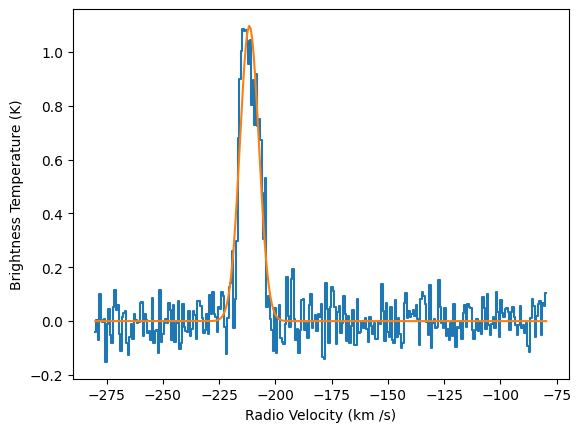

In [16]:
# Pixel location
y, x = 32, 32

spec = spatmasked_cube[:, y, x]

# Slice out the guesses at this location
guesses = [masked_peaktemp[y:y+1, x:x+1].value,
           masked_moment1[y:y+1, x:x+1].value,
           masked_equivwidth[y:y+1, x:x+1].value]

# The 1D Gaussian model with initial guesses for parameters
g_init = models.Gaussian1D(amplitude=guesses[0],
                           mean=guesses[1],
                           stddev=guesses[2])

# And fit with the Levenberg-Marquardt algorithm and least squares statistic.
fit_g = fitting.LevMarLSQFitter()
g_fit_spec = fit_g(g_init,  cube.spectral_axis, spatmasked_cube._get_filled_data(fill=np.nan)[:, y, x])

print(g_fit_spec)

plt.plot(spec.spectral_axis, spec.value, drawstyle='steps-mid')
plt.plot(spec.spectral_axis.value, g_fit_spec(spec.spectral_axis))
plt.ylabel("Brightness Temperature (K)")
plt.xlabel("Radio Velocity (km /s)")

The resulting fit is reasonable. There may be additional line structure that requires a more complex model, but that is beyond the scope of this example.

## Fitting the whole cube ##

At this stage, most of the hard work is already done! To expand from fitting a chunk above to the whole cube, we can use dask to handle both loading the data and parallelizing the process, and we make use of ``parallel_fit_model_nd`` to handle the fitting part.

We will run the fitting on multiple threads. We will also specify the guess arrays, using the equivalent width for the line width guesses.

In [17]:
from astropy.modeling.fitting_parallel import parallel_fit_model_nd
from tqdm.dask import TqdmCallback

# The 1D Gaussian model with initial guesses for parameters
g_init = models.Gaussian1D(amplitude=masked_peaktemp.value,
                           mean=masked_moment1.value,
                           stddev=masked_equivwidth.value)

with TqdmCallback(desc="fitting"):

    g_fit = parallel_fit_model_nd(
        model=g_init,
        fitter=fit_g,
        data=spatmasked_cube._get_filled_data(fill=np.nan),
        fitting_axes=0,
        world={0: cube.spectral_axis.value},
        scheduler='threads',
    )

fitting:   0%|          | 0/1057 [00:00<?, ?it/s]

## Fit results ##

To finish off this fitting example, we will visually example the fit parameters and compare with the initial guesses.

First, the peak versus fitted amplitudes:

Max residual: 11.402426366853376
Min residual: -1.269384834177893


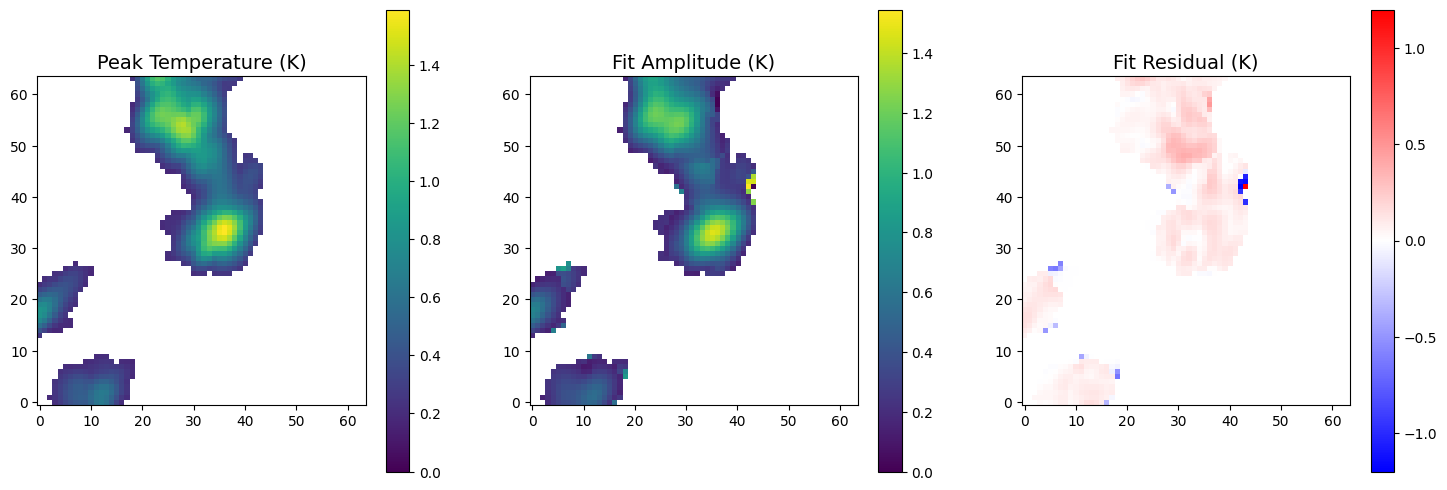

In [18]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('Peak Temperature (K)', fontsize=14)
plt.imshow(masked_peaktemp.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Amplitude (K)', fontsize=14)
plt.imshow(g_fit.amplitude.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (K)', fontsize=14)
plt.imshow(masked_peaktemp.value - g_fit.amplitude.value, cmap='bwr', vmax=1.2, vmin=-1.2, origin='lower')
plt.colorbar()

print(f"Max residual: {np.nanmax(masked_moment0.value - g_fit.amplitude.value)}")
print(f"Min residual: {np.nanmin(masked_moment0.value - g_fit.amplitude.value)}")

The fit amplitudes closely match the initial guesses, though a few outliers in the fits warrant reviewing.

Next, the centroid velocity:

Max residual: 2.620709728272601
Min residual: -2.819628567830705


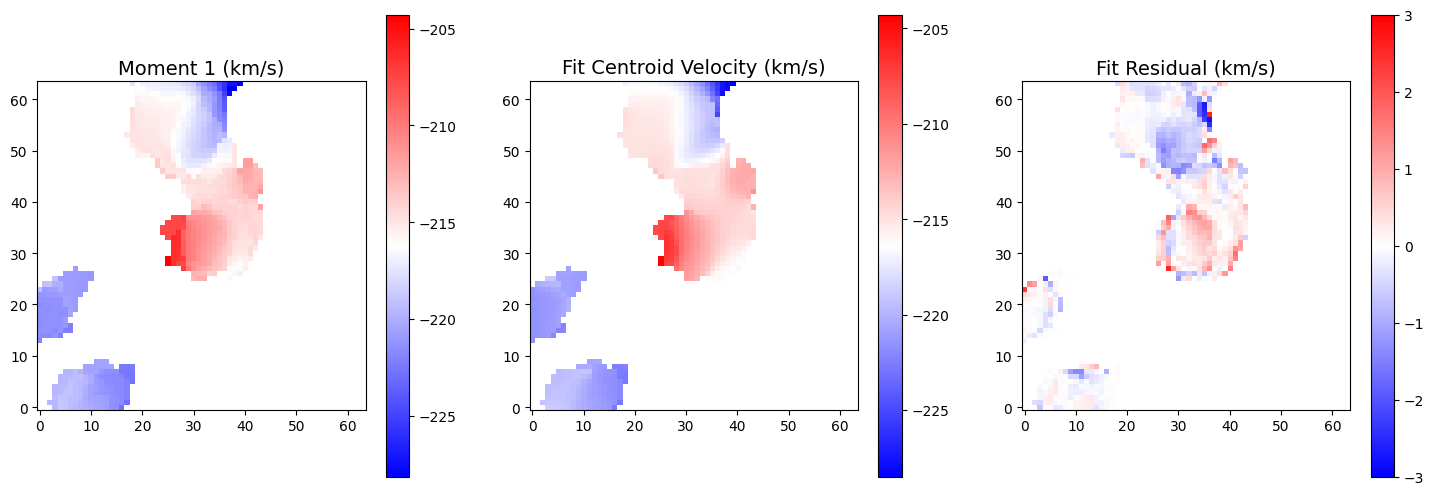

In [19]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('Moment 1 (km/s)', fontsize=14)
plt.imshow(masked_moment1.value, cmap='bwr', origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Centroid Velocity (km/s)', fontsize=14)
plt.imshow(g_fit.mean.value, cmap='bwr', origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (km/s)', fontsize=14)
plt.imshow(masked_moment1.value - g_fit.mean.value, cmap='bwr', vmax=3, vmin=-3, origin='lower')
plt.colorbar()

print(f"Max residual: {np.nanmax(masked_moment1.value - g_fit.mean.value)}")
print(f"Min residual: {np.nanmin(masked_moment1.value - g_fit.mean.value)}")

These again are quite similar. The fitted centroid velocity looks smoother. For reference, the channel width is 0.7 km/s.

Lastly, the line widths:

Max residual: 1.1474030039027872
Min residual: -5.1946133796482785


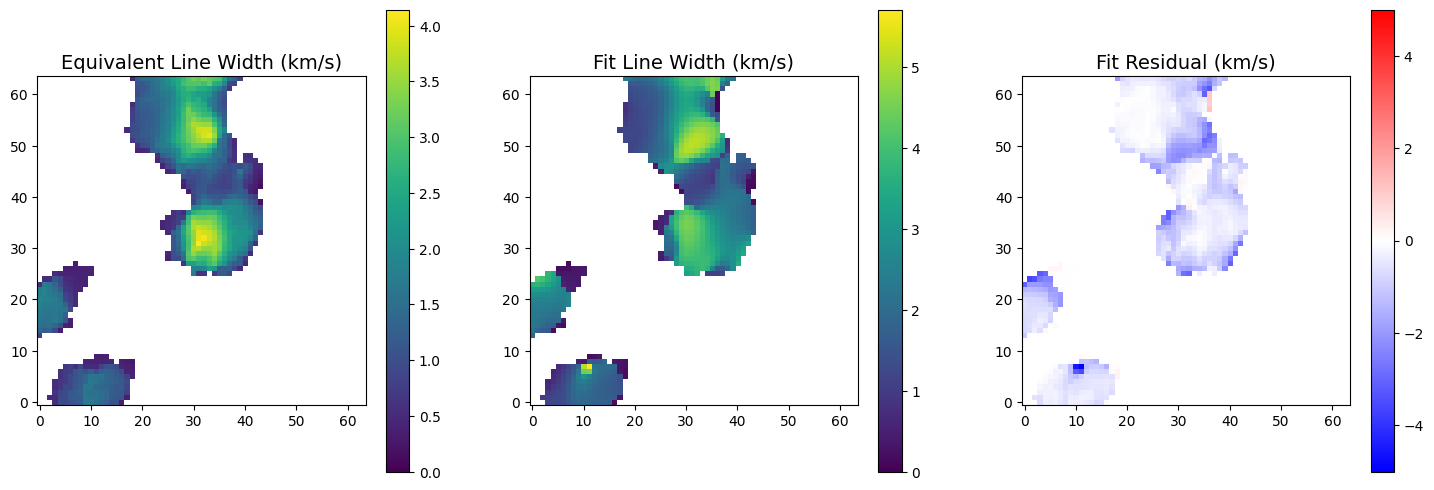

In [20]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('Equivalent Line Width (km/s)', fontsize=14)
plt.imshow(masked_equivwidth.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Line Width (km/s)', fontsize=14)
plt.imshow(g_fit.stddev.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (km/s)', fontsize=14)
plt.imshow(masked_equivwidth.value - g_fit.stddev.value, cmap='bwr', vmax=5, vmin=-5, origin='lower')
plt.colorbar()

print(f"Max residual: {np.nanmax(masked_equivwidth.value - g_fit.stddev.value)}")
print(f"Min residual: {np.nanmin(masked_equivwidth.value - g_fit.stddev.value)}")

The structure in the maps has changed somewhat between the equivalent line width and fitted line width, and the fitted line width tends to be larger. This suggests (1) the equivalent line width tends to underestimate the line width, and (2) there is additional line structure that is not fully captured by a single Gaussian.

We can make one final comparison by computing the integrated intensity for the model and comparing it to the data itself:

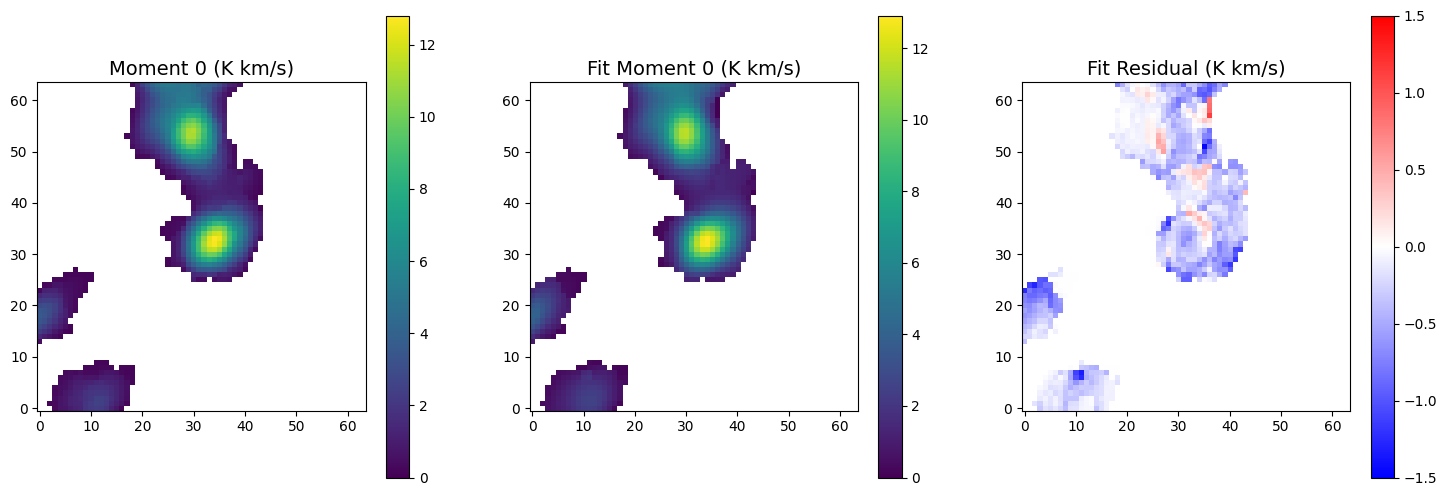

In [21]:
plt.figure(figsize=(18, 6))

integrated_intensity = np.sqrt(2 * np.pi) * g_fit.amplitude.value * u.K * g_fit.stddev.value * u.km / u.s

plt.subplot(131)
plt.title('Moment 0 (K km/s)', fontsize=14)
plt.imshow(masked_moment0.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title('Fit Moment 0 (K km/s)', fontsize=14)
plt.imshow(integrated_intensity.value, vmin=0, origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title('Fit Residual (K km/s)', fontsize=14)
plt.imshow(masked_moment0.value - integrated_intensity.value, cmap='bwr', vmax=1.5, vmin=-1.5, origin='lower')
plt.colorbar()


The moment 0 integrated intensity maps are similar, though the fit map tends to be larger. This is expected because of how the signal mask is created, with the $3\sigma$ signal-to-noise cut-off. Because the fit is continuous, the fitted integrated intensity may better capture the faint emission down to the noise level.

Altogether, the fitting has generally been successful for this proof-of-concept cube fitting use `dask` with `astropy.modeling`.

*Note that we have not included goodness-of-fit statistics for this example. These are, of course, crucial when using the fitting for scientific results. However, this example is primarily as a proof-of-concept and will need to be expanded and generalized for full usage.*

The model cube can be evaluated by passing the cube's spectral axis, though expanded to 3D:

** Be careful running the following with large cubes! This will produce an array with the same dimensions as the whole cube.**

In [22]:
model_cube = g_fit(cube.spectral_axis[:, None, None].value)

And to compare, we can make an equivalent peak intensity map using the max along the spectral dimension:

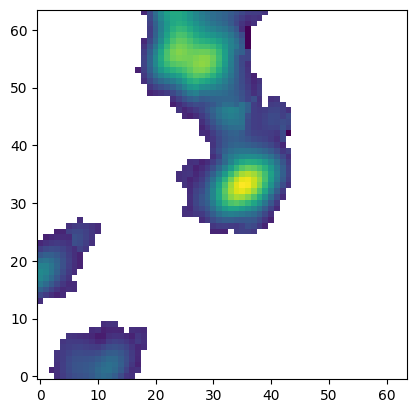

In [23]:
plt.imshow(model_cube.max(0), origin='lower')

This appears as expected. `model_cube` can be used to inspect the fits and compare to the data.

## Performance ##

For large cubes, the parallelization may become input/output (I/O) limited when dask reads in chunks of the cube. Because we require the full spectral dimension to be returned, we already may need the `DaskSpectralCube.rechunk` function. Above we use this simply to force using 16 chunks for this tutorial. However, when `zarr` and `fsspec` are installed, the rechunked cube can be temporarily saved as a zarr file by setting `save_to_tmp_dir=True`. This may improve the fitting performance at the expense of the time to write out the temporary file and the need for $\sim2\times$ the storage space.